In [1]:
import numpy as np
from scipy.signal import convolve2d

In [2]:
N = 4
lattices = np.tile([[-1, 1], [1, -1]], (N // 2, N // 2))
#lattices = np.random.choice([-1, 1], size=[1, 4, 4])
J = np.array([1.0, 0.0])

In [3]:
def periodic_padding(lattice, padding=1):
    '''
    Create a periodic padding (wrap) around the lattice, to emulate periodic 
    boundary conditions
    From https://github.com/tensorflow/tensorflow/issues/956, FedericoMuciaccia suggestion
    '''

    upper_pad = lattice[-padding:, :]
    lower_pad = lattice[:padding, :]

    partial_lattice = np.concatenate([upper_pad, lattice, 
                                      lower_pad], axis=0)

    left_pad = partial_lattice[:, -padding:]
    right_pad = partial_lattice[:, :padding]

    padded_lattice = np.concatenate([left_pad, partial_lattice, 
                                     right_pad], axis=1)

    return padded_lattice

In [4]:
def Hamiltonian(lattice: np.ndarray, J: np.ndarray,
                B: float, periodic: bool = False) -> float:
    J1, J2 = J
    neighbors = np.array([[0, 1, 0],
                          [1, 0, 1],
                          [0, 1, 0]])
    n_neighbors = np.array([[1, 0, 1],
                            [0, 0, 0],
                            [1, 0, 1]])

    if periodic:
        padded = periodic_padding(lattice)
        conv1 = convolve2d(padded, neighbors, mode='valid')
        conv1 = np.multiply(conv1, lattice) / 2
        conv2 = convolve2d(padded, n_neighbors, mode='valid')
        conv2 = np.multiply(conv2, lattice) / 2
    else:
        conv1 = convolve2d(lattice, neighbors, mode='same')
        conv1 = np.multiply(conv1, lattice) / 2  # I have to test
        conv2 = convolve2d(lattice, neighbors, mode='same')
        conv2 = np.multiply(conv2, lattice) / 2  # I have to test

    return -J1 * np.sum(conv1) + J2 * np.sum(conv2) - B * np.sum(lattice)

In [5]:
def _Metropolis(lattice:np.ndarray, J:np.ndarray, 
                B: np.float32, T:np.float32, periodic:bool) -> np.ndarray:

    J1, J2 = J
    neighbors = np.array([[0, 1, 0],
                          [1, 0, 1],
                          [0, 1, 0]])
    n_neighbors = np.array([[1, 0, 1],
                            [0, 0, 0],
                            [1, 0, 1]])
    even_filter = np.zeros(shape=lattice.shape, dtype=bool)
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            even_filter[i, j] = (i+j) % 2 == 0

    def delta_energy(lattice):
        if periodic:
            padded = periodic_padding(lattice)
            conv1 = convolve2d(padded, neighbors, mode='valid')
            conv1 = np.multiply(conv1, lattice) / 2
            
            conv2 = convolve2d(padded, n_neighbors, mode='valid')
            conv2 = np.multiply(conv2, lattice) / 2
        else:
            conv1 = convolve2d(lattice, neighbors, mode='same')
            conv1 = np.multiply(conv1, lattice) /2  # I have to test
            
            conv2 = convolve2d(lattice, neighbors, mode='same')
            conv2 = np.multiply(conv2, lattice) / 2  # I have to test
        
        conv = (J1 * conv1 - J2 * conv2 + B * lattice)
        
        return 2 * conv

    delta_even = delta_energy(lattice)
    
    random = np.random.uniform(size=delta_even.shape)
    condition_1 = np.less(delta_even, 0)
    condition_2 = np.less(random,
                          np.exp(- delta_even / T))
    cond = np.logical_or(condition_1, condition_2)
    condition = np.logical_and(even_filter, cond)

    lattice = np.where(condition, -lattice, lattice)
    delta_odd = delta_energy(lattice)

    condition_1 = np.less(delta_odd, 0)
    condition_2 = np.less(random,
                          np.exp(- delta_odd / T))
    cond = np.logical_or(condition_1, condition_2)
    condition = np.logical_and(np.logical_not(even_filter), cond)

    return np.where(condition, -lattice, lattice)

In [14]:
N = 8
n_sim = 1
lattices = np.tile([[-1, 1], [1, -1]], (n_sim, N // 2, N // 2))
#lattices = np.ones(shape=(n_sim, N, N))
J = np.array([1.0, 0.9])

print(lattices[0])

for time in range(2000):
    for ensamble in range(lattices.shape[0]):
        lattices[ensamble] = _Metropolis(lattices[ensamble], J, 0.0, 0.1, True)
        
lattices[0], lattices[0].mean()

[[-1  1 -1  1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [-1  1 -1  1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [-1  1 -1  1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [-1  1 -1  1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]]


(array([[-1,  1, -1, -1, -1, -1, -1, -1],
        [ 1,  1,  1, -1, -1, -1, -1, -1],
        [ 1,  1,  1,  1, -1, -1, -1,  1],
        [ 1,  1,  1,  1,  1, -1,  1,  1],
        [ 1,  1,  1,  1, -1, -1, -1,  1],
        [ 1,  1,  1, -1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1]]),
 -0.21875)

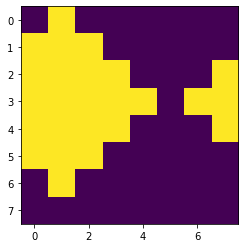

In [15]:
import matplotlib.pyplot as plt

plt.imshow(lattices[0])

In [16]:
np.abs(lattices.mean(axis=(1, 2))).mean()

0.21875

In [17]:
1 / np.linspace(1, 7, 10)

array([1.        , 0.6       , 0.42857143, 0.33333333, 0.27272727,
       0.23076923, 0.2       , 0.17647059, 0.15789474, 0.14285714])